In [2]:
import os
import time
import math
import numpy as np
from IPython.utils import io
import pandas as pd
from tqdm import tqdm
from dataclasses import dataclass
from typing import List, Union 
import matplotlib.pyplot as plt
import matplotlib
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import ta
import torch
import torch.nn as nn

/Users/matteogiori/trycloneinsider/TradingBot/.venv313/lib/python3.13/site-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [3]:
from PERMUTATIONS import get_permutation
from strategy import ARSIstrat

                       Open    High      Low    Close  Volume
time                                                         
2018-01-02 14:30:00  156.50  157.88  156.170  157.840  875636
2018-01-02 15:30:00  157.85  158.15  157.630  158.000  424637
2018-01-02 16:30:00  158.01  158.06  157.895  157.990  161584
2018-01-02 17:30:00  157.98  158.10  157.900  158.080  131613
2018-01-02 18:30:00  158.08  158.33  158.070  158.265  251044


In [4]:
def load_data(csv_path: str, start='2018-01-01', end_excl='2024-01-01'):
    df = pd.read_csv(csv_path)
    df['time'] = pd.to_datetime(df['time'].astype(int), unit='s')
    df.set_index('time', inplace=True)
    df.sort_index(inplace=True)
    df = df.loc[(df.index >= start) & (df.index < end_excl)].copy()
    df = df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'})
    return df

In [5]:
def make_strat(p):
    class Tuned(ARSIstrat):
        sl_pct = float(p['sl_pct'])
        n_fast = int(p['n_fast'])
        n_slow = int(p['n_slow'])
        n_vslow = int(p['n_vslow'])
        sig_len = int(p['sig_len'])
    return Tuned

In [6]:
def run_bt(data: pd.DataFrame, params: dict, spread: float = 0.0001):
    Strat = make_strat(params)
    bt = Backtest(data, Strat, cash=1_000_000, commission=0.0, spread=spread, finalize_trades=True)
    
    with io.capture_output():
        stats = bt.run()
    

    sharpe = float(stats.get('Sharpe Ratio', 0.0))
    # turnover proxy
    trades = int(getattr(stats, '_trades', pd.DataFrame()).shape[0]) if hasattr(stats, '_trades') else 0
    days = max(1, (data.index[-1] - data.index[0]).days)
    tpd = trades / days
    score = sharpe - 0.02 * tpd
    return score, tpd, stats

In [7]:
SPACE = {
    'sl_pct': (0.001, 0.02, 'float'),  # 0.1% .. 2%
    'n_fast': (5, 25, 'int'),
    'n_slow': (10, 55, 'int'),
    'n_vslow': (30, 120, 'int'),
    'sig_len': (5, 30, 'int'),
}
ORDER = list(SPACE.keys())


def encode(params_dict):
    z = []
    for k in ORDER:
        lo, hi, typ = SPACE[k]
        v = float(params_dict[k])
        v = (v - lo) / (hi - lo)
        z.append(np.clip(v, 0, 1))
    return np.array(z, dtype=np.float32)


def decode(z):
    out = {}
    for i, k in enumerate(ORDER):
        lo, hi, typ = SPACE[k]
        v = lo + float(np.clip(z[i], 0, 1)) * (hi - lo)
        if typ == 'int':
            v = int(round(v))
            v = int(min(max(v, int(lo)), int(hi)))
        else:
            v = float(v)
        out[k] = v
    return out


def sample_params(n):
    Ps = []
    for _ in range(n):
        d = {}
        for k, (lo, hi, typ) in SPACE.items():
            if typ == 'int':
                d[k] = int(np.random.randint(int(lo), int(hi) + 1))
            else:
                d[k] = float(np.random.uniform(lo, hi))
        Ps.append(d)
    return Ps

In [8]:
class Surrogate(nn.Module):
    def __init__(self, d, p_dropout=0.15):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)


def fit_surrogate(X, y, steps=2000, lr=1e-3, wd=1e-3, val_frac=0.2, patience=200):
    from copy import deepcopy
    X = np.array(X, dtype=np.float32); y = np.array(y, dtype=np.float32)
    n = len(X)
    if n < 10:
        raise ValueError("Need at least 10 samples to fit surrogate")
    idx = np.random.permutation(n)
    k = int(n * (1 - val_frac))
    tr, va = idx[:k], idx[k:]
    Xt = torch.tensor(X[tr]); yt = torch.tensor(y[tr])
    Xv = torch.tensor(X[va]); yv = torch.tensor(y[va])

    model = Surrogate(X.shape[1])
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    loss = nn.MSELoss()

    best = (1e9, None)
    bad = 0
    for _ in range(steps):
        model.train(); opt.zero_grad()
        pred = model(Xt); l = loss(pred, yt); l.backward(); opt.step()
        model.eval()
        with torch.no_grad():
            v = loss(model(Xv), yv).item()
            if v < best[0]:
                best = (v, deepcopy(model.state_dict())); bad = 0
            else:
                bad += 1
            if bad > patience:
                break
    model.load_state_dict(best[1])
    model.eval()
    return model


def argmax_on_surrogate(model, starts, iters=400, lr=0.05):
    best_z, best_pred = None, -1e9
    for z0 in starts:
        z = torch.tensor(z0.copy(), dtype=torch.float32, requires_grad=True)
        opt = torch.optim.Adam([z], lr=lr)
        for _ in range(iters):
            opt.zero_grad()
            z_c = torch.clamp(z, 0.0, 1.0)
            pred = model(z_c)
            loss = -pred
            loss.backward(); opt.step()
        with torch.no_grad():
            z_c = torch.clamp(z, 0.0, 1.0)
            pred = model(z_c).item()
            if pred > best_pred:
                best_pred, best_z = pred, z_c.detach().numpy()
    return best_z, best_pred

In [9]:
SPLITS = [
    ('2018-01-01', '2020-12-31', '2021-01-01', '2021-06-30'),
    ('2018-07-01', '2021-06-30', '2021-07-01', '2021-12-31'),
    ('2019-01-01', '2021-12-31', '2022-01-01', '2022-06-30'),
    ('2019-07-01', '2022-06-30', '2022-07-01', '2022-12-31'),
]


def slice_df(df, s, e):
    return df.loc[s:e]


def robust_validation_score(df_full, p):
    sharpes, tpds = [] , []
    for (tr_s, tr_e, val_s, val_e) in SPLITS:
        train = slice_df(df_full, tr_s, tr_e)
        if len(train) > 0:
            train = train.iloc[:-5]  # embargo 5 bars
        valid = slice_df(df_full, val_s, val_e)
        # friction jitter
        for sp in [0.00008, 0.0001, 0.00012]:
            s, t, _ = run_bt(valid, p, spread=sp)
            sharpes.append(s)
            tpds.append(t)
    sharpes = np.array(sharpes, float)
    tpds = np.array(tpds, float)
    q25 = float(np.quantile(sharpes, 0.25))
    std = float(np.std(sharpes))
    tpd = float(np.median(tpds))
    return q25 - 0.5 * std - 0.02 * tpd

In [10]:
np.random.seed(42)

csv_path = 'BATS_QQQ, 60_a45be.csv'
full_df = load_data(csv_path, start='2018-01-01', end_excl='2024-01-01')

# Define periods
df_train = full_df.loc['2018-01-01':'2021-12-31']
df_test = full_df.loc['2023-01-01':'2023-12-31']

print(df_train.loc['2018-02-01':'2018-02-03'])

                        Open    High     Low    Close   Volume
time                                                          
2018-02-01 14:30:00  168.120  169.30  168.10  168.860   778080
2018-02-01 15:30:00  168.890  169.56  168.77  169.000   369077
2018-02-01 16:30:00  169.030  169.56  169.01  169.350   308644
2018-02-01 17:30:00  169.350  169.72  169.33  169.610   233919
2018-02-01 18:30:00  169.610  169.62  168.15  168.500   536976
2018-02-01 19:30:00  168.530  168.84  168.16  168.180   472291
2018-02-01 20:30:00  168.180  168.28  167.43  167.970   881835
2018-02-02 14:30:00  167.350  167.69  165.47  166.550  1440870
2018-02-02 15:30:00  166.550  166.98  166.29  166.455   468137
2018-02-02 16:30:00  166.445  166.80  165.88  166.800   338315
2018-02-02 17:30:00  166.800  166.85  165.71  166.030   444612
2018-02-02 18:30:00  166.050  166.17  165.32  165.410   700824
2018-02-02 19:30:00  165.420  165.96  164.69  165.170  1402530
2018-02-02 20:30:00  165.180  165.32  164.48  164.560  

In [11]:
def run_model_for_params(ohlc: pd.DataFrame,K : int):
    
    # 1) 
    N_INIT = 60
    pool = sample_params(N_INIT)
    X, y = [], []
    t0 = time.perf_counter()
    for p in pool:
        s_train, _, _ = run_bt(ohlc, p)
        X.append(encode(p)); y.append(s_train)
    #print(f"Initial evals: {len(y)} done in {time.perf_counter()-t0:.1f}s. Best train={max(y):.3f}")

    # 2)
    N_ROUNDS = 3
    TOP_K = 8
    N_STARTS = 16
    for r in range(N_ROUNDS):
        surr = fit_surrogate(X, y, steps=1500, lr=1e-3, wd=1e-3, val_frac=0.2, patience=150)
        starts = [np.random.rand(len(ORDER)) for _ in range(N_STARTS - 4)]
        # seed from best-so-far
        top_idx = np.argsort(y)[-4:]
        starts += [X[i] for i in top_idx]
        cand = []
        for z0 in starts:
            z_star, _ = argmax_on_surrogate(surr, [z0], iters=250, lr=0.05)
            cand.append(z_star)
        # dedupe
        uniq = []
        for z in cand:
            if all(np.linalg.norm(z - u) > 0.05 for u in uniq):
                uniq.append(z)
        preds = surr(torch.tensor(np.array(uniq), dtype=torch.float32)).detach().numpy()
        order = np.argsort(preds)[::-1][:TOP_K]
        added = 0
        for idx in order:
            p = decode(uniq[idx])
            s_train, _, _ = run_bt(df_train, p)
            X.append(encode(p)); y.append(s_train)
            added += 1
        #print(f"Round {r+1}: added {added}, best train={max(y):.3f}")

    # 3)
    candidates = [decode(x) for x in X]
    val_scores = []
    for p in candidates:
        vs = robust_validation_score(full_df, p)
        val_scores.append(vs)
    idxs = np.argsort(val_scores)[::-1]
    K_FINAL = K
    finalists = [candidates[i] for i in idxs[:K_FINAL]]
    scores = [val_scores[i] for i in idxs[:K_FINAL]]
    #print("Top finalists by robust validation:")
    #for i, p in enumerate(finalists, 1):
        #print(f"{i}. {p} | robust_score={val_scores[idxs[i-1]]:.3f}")
    return finalists, scores

        

In [12]:
def winner_SR(ohlc: pd.DataFrame):
    _, best_SR = run_model_for_params(ohlc,1)
    return best_SR

In [13]:
def signal_from_stats(ohlc : pd.DataFrame, params : dict, spread : float = 0.0001, include_exit_bar = False):
    """
    Return a per-bar signal Series aligned to stats['_equity_curve'].index.
    -1 = short, 0 = flat, 1 = long.

    include_exit_bar:
        False (default): flat on the bar where exit executes (typical next-open execution).
        True: mark position as active through the exit bar (if you model close-on-close exits).
    """

    _, _ , stats = run_bt(ohlc,params)
    ec = stats['_equity_curve']           # index = backtest bars
    N = len(ec.index)

    # net units held per bar (handles pyramiding/overlaps if you allowed them)
    net_units = np.zeros(N, dtype=float)

    trades = stats['_trades']             # columns include EntryBar, ExitBar, Size, ...
    for _, tr in trades.iterrows():
        start = int(tr.EntryBar)
        if pd.isna(tr.ExitBar):
            end = N
        else:
            end = int(tr.ExitBar) + (1 if include_exit_bar else 0)

        net_units[start:end] += tr.Size   # sum overlapping trades; shorts are negative

    sig = np.sign(net_units).astype(int)  # -> -1/0/1
    return pd.Series(sig, index=ec.index, name='signal')

In [14]:
def _order_ok(p):
    return (
        (p.n_slow  - p.n_fast  >= 3) and
        (p.n_vslow - p.n_slow  >= 7) and
        (p.n_fast  < p.n_slow  < p.n_vslow)   and
        (p.sig_len > 0) and (p.sl_pct > 0)
    )

In [ ]:
def walkforward_ARSI(ohlc_full: pd.DataFrame, train_lookback: int = 7 * 365 * 4, train_step: int = 7*30):

    n = len(ohlc_full)
    wf_signal = np.full(n, np.nan)
    tmp_signal = None
    
    next_train = train_lookback

    SL_GRID = [round(x, 3) for x in np.arange(0.001, 0.020 + 0.0005, 0.001)]

    param_space = dict(
        n_fast  = list(range(5, 26, 1)),
        n_slow  = list(range(10, 56, 1)),
        n_vslow = list(range(30, 121, 1)),
        sig_len = list(range(5, 31, 1)),
        sl_pct  = SL_GRID,)                       


    for i in range(next_train, n):
        if i == next_train:
            
            ohlc = ohlc_full.iloc[i-train_lookback:i]
            BTF = Backtest(ohlc, ARSIstrat, cash=1_000_000, commission=0.0, spread=0.0001, finalize_trades=True)
             
            with io.capture_output():
                s, _ = BTF.optimize(
                    **param_space,
                    maximize='Sharpe Ratio',
                    return_heatmap=True,
                    constraint=_order_ok,
                    method='sambo',
                    max_tries=2500,
                    random_state=42
                    )
            best = s._strategy
            best_params = {
                'n_fast' : int(best.n_fast),
                'n_slow' : int(best.n_slow),
                'n_vslow' : int(best.n_vslow),
                'sig_len' : int(best.sig_len),
                'sl_pct' : int(best.sl_pct)
                }
            
            tmp_signal = signal_from_stats(ohlc_full,best_params)
            

            

            #bl1, bl2 , _ = OPTI_MACO(ohlc.iloc[i-train_lookback:i])
            #tmp_signal, _ = MA_CROSSOVER(ohlc, bl1, bl2)


            next_train += train_step
        
        wf_signal[i] = tmp_signal.iloc[i]
    
    return wf_signal

In [16]:
best_finalists, best_SRs = run_model_for_params(df_train, 25)

KeyboardInterrupt: 

In [ ]:
print(best_finalists)
print(best_SRs)
notrobustSR = []
for t in best_finalists:
    MBNRSR, _ , _ = run_bt(df_train,t)
    notrobustSR.append(MBNRSR)
print(notrobustSR)

[{'sl_pct': 0.004858163237571716, 'n_fast': 17, 'n_slow': 41, 'n_vslow': 100, 'sig_len': 23}, {'sl_pct': 0.004397631511092186, 'n_fast': 12, 'n_slow': 16, 'n_vslow': 96, 'sig_len': 21}, {'sl_pct': 0.0017682381980121135, 'n_fast': 19, 'n_slow': 24, 'n_vslow': 119, 'sig_len': 14}, {'sl_pct': 0.004972360804677009, 'n_fast': 14, 'n_slow': 44, 'n_vslow': 36, 'sig_len': 20}, {'sl_pct': 0.00406320433318615, 'n_fast': 6, 'n_slow': 51, 'n_vslow': 74, 'sig_len': 29}, {'sl_pct': 0.004128461137413979, 'n_fast': 13, 'n_slow': 46, 'n_vslow': 80, 'sig_len': 14}, {'sl_pct': 0.0026813575997948645, 'n_fast': 12, 'n_slow': 30, 'n_vslow': 109, 'sig_len': 17}, {'sl_pct': 0.003964354246854782, 'n_fast': 23, 'n_slow': 32, 'n_vslow': 104, 'sig_len': 15}, {'sl_pct': 0.007162555426359176, 'n_fast': 11, 'n_slow': 42, 'n_vslow': 30, 'sig_len': 29}, {'sl_pct': 0.0042399582862854, 'n_fast': 11, 'n_slow': 27, 'n_vslow': 33, 'sig_len': 29}, {'sl_pct': 0.004342579841613769, 'n_fast': 8, 'n_slow': 42, 'n_vslow': 43, 's

In-sample Robust Sarpe Ratio :  0.6074807158937355 ,  Best n_fast :  17 ,  Best n_slow :  41 ,  Best n_vslow :  100 ,  Best stop loss   0.004858163237571716 ,  Best Signal lenght :  23


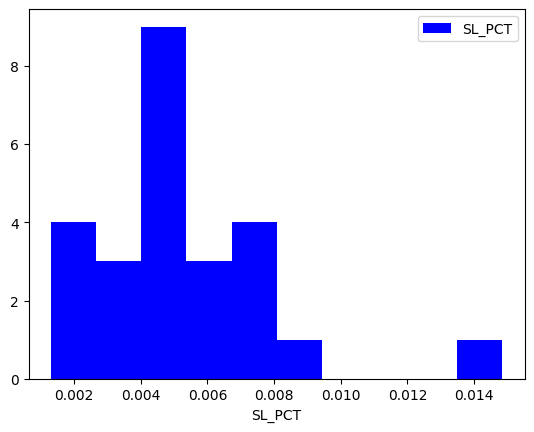

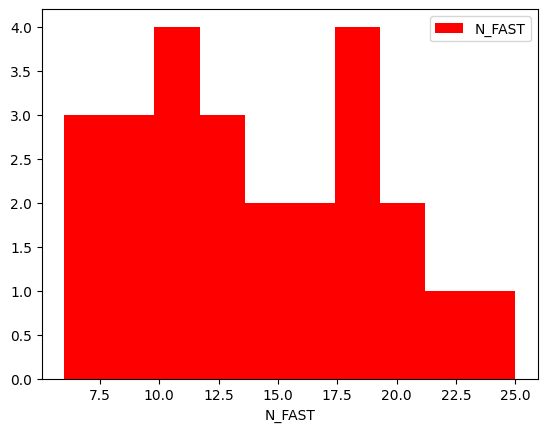

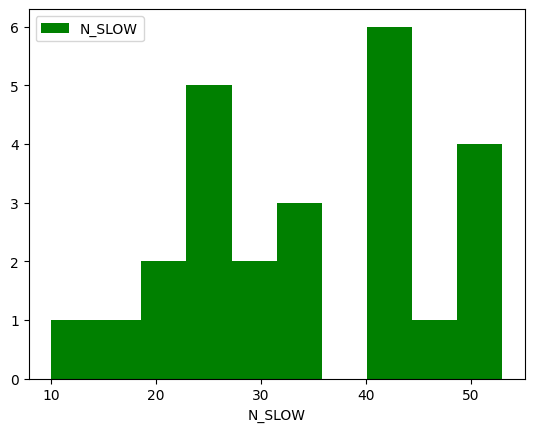

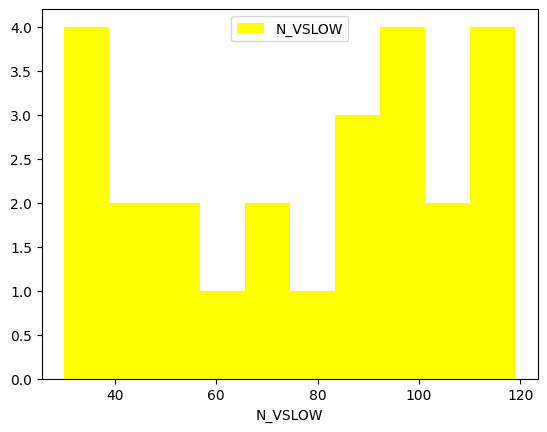

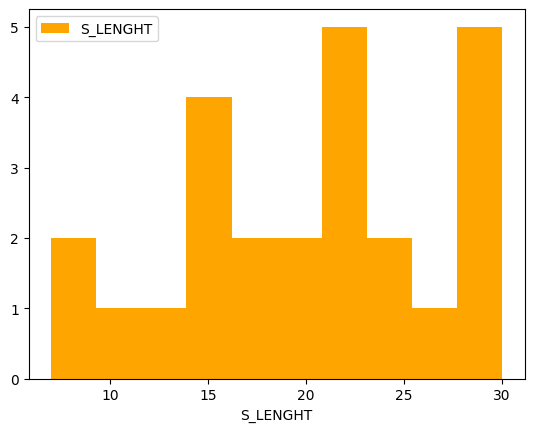

In [ ]:
SR_OPTI_0 = best_SRs[0]
PARAM_OPTI_0 = best_finalists[0]
SL_0 = PARAM_OPTI_0['sl_pct']
N_Fast = PARAM_OPTI_0['n_fast']
N_Slow = PARAM_OPTI_0['n_slow']
N_VSlow = PARAM_OPTI_0['n_vslow']
S_Lenght = PARAM_OPTI_0['sig_len']
print("In-sample Robust Sarpe Ratio : ", SR_OPTI_0, ",  Best n_fast : ", N_Fast, ",  Best n_slow : ", N_Slow, ",  Best n_vslow : ", N_VSlow, ",  Best stop loss  ", SL_0, ",  Best Signal lenght : ", S_Lenght)

SL_PCT = []
N_FAST = []
N_SLOW = []
N_VSLOW = []
S_LENGHT = []

for tau in best_finalists :
    SL_PCT.append(tau['sl_pct'])
    N_FAST.append(tau['n_fast'])
    N_SLOW.append(tau['n_slow'])
    N_VSLOW.append(tau['n_vslow'])
    S_LENGHT.append(tau['sig_len'])

pd.Series(SL_PCT).hist(color='blue', label='SL_PCT')
plt.xlabel("SL_PCT")
plt.grid(False)
plt.legend()
plt.show()

pd.Series(N_FAST).hist(color='red', label='N_FAST')
plt.xlabel("N_FAST")
plt.grid(False)
plt.legend()
plt.show()

pd.Series(N_SLOW).hist(color='green', label='N_SLOW')
plt.xlabel("N_SLOW")
plt.grid(False)
plt.legend()
plt.show()

pd.Series(N_VSLOW).hist(color='yellow', label='N_VSLOW')
plt.xlabel("N_VSLOW")
plt.grid(False)
plt.legend()
plt.show()

pd.Series(S_LENGHT).hist(color='orange', label='S_LENGHT')
plt.xlabel("S_LENGHT")
plt.grid(False)
plt.legend()
plt.show()


Backtest.run:   0%|          | 0/6842 [00:00<?, ?bar/s]

Le rendement de la strategie avec un signal mais sans spread est : 2.2917633831592243
Le rendement avec Backtesting et donc spread nous donne 2.426459901503824


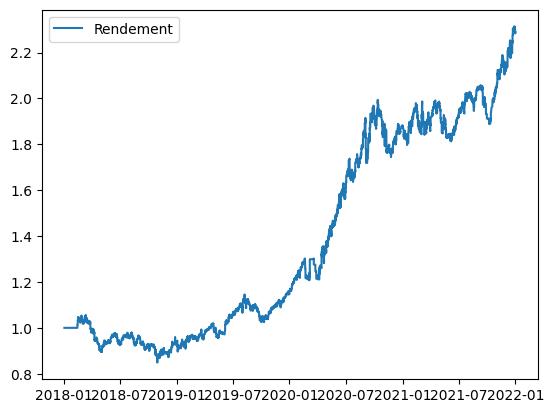

In [ ]:
SIG = signal_from_stats(df_train,PARAM_OPTI_0)

strat_with_best_params = make_strat(PARAM_OPTI_0)
understand = Backtest(df_train, strat_with_best_params, cash=1_000_000, commission=0.0, finalize_trades=True)
statistics = understand.run()



df_ud = df_train.copy()
df_ud['returns'] = np.log(df_ud['Close']).diff().shift(-1) 
df_ud['system_returns'] = df_ud['returns']*SIG
print(f"Le rendement de la strategie avec un signal mais sans spread est : {np.exp(df_ud['system_returns']).cumprod().iloc[-2]}")
print(f"Le rendement avec Backtesting et donc spread nous donne {statistics['Return [%]']/100}")
plt.plot(np.exp(df_ud['system_returns']).cumprod(), label = 'Rendement')
plt.legend(loc=2)
plt.show()

In [ ]:
n_permutations = 1000
perm_better_count1 = 1
perm_better_counts = np.ones(25)
permuted_SRs = []
permuted_25best_SR = []
p_vals_25best = []
print("In-Sample MCPT")

local_df_train = df_train.copy()
local_SR_OPTI_0 = SR_OPTI_0
local_finalists = best_finalists.copy()

for perm_i in tqdm(range(1, n_permutations+1)):

    train_perm = get_permutation(local_df_train)

    RVSs = []
    for l in local_finalists :
        RVSs.append(run_bt(train_perm, l)[0])
    
    for i in range(25) :
        if RVSs[i] >= notrobustSR[i] :
            perm_better_counts[i] += 1


    best_perm_SR = float(winner_SR(train_perm)[0])

    
    if best_perm_SR >= local_SR_OPTI_0:
        perm_better_count1 += 1

    permuted_SRs.append(best_perm_SR)

insample_mcpt_pval = perm_better_count1 / n_permutations

insample_mcpt_pval_25_best = []

for t in range(25) :
    a = float(perm_better_counts[t] / n_permutations)
    insample_mcpt_pval_25_best.append(a)


print(f"Les 25 meilleurs set de param on donner des p-val : {insample_mcpt_pval_25_best}")
print(f"In-sample MCPT P-Value: {insample_mcpt_pval}")
plt.style.use('dark_background')
pd.Series(permuted_SRs).hist(color='blue', label='Permutations')
plt.axvline(local_SR_OPTI_0, color='red', label='Real')
plt.xlabel("Profit Factor")
plt.title(f"In-sample MCPT. P-Value: {insample_mcpt_pval}")
plt.grid(False)
plt.legend()
plt.show()

In-Sample MCPT


  0%|          | 5/1000 [03:15<10:42:21, 38.74s/it]